Begun 4/27/24

The purpose of this notebook is to try fitting the noise spectra to a power law for extrapolation instead of using interpolation to see if this makes the likelihoods nicer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [4]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [5]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [6]:
# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90 # Do we want to turn off filtering here?
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2 = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


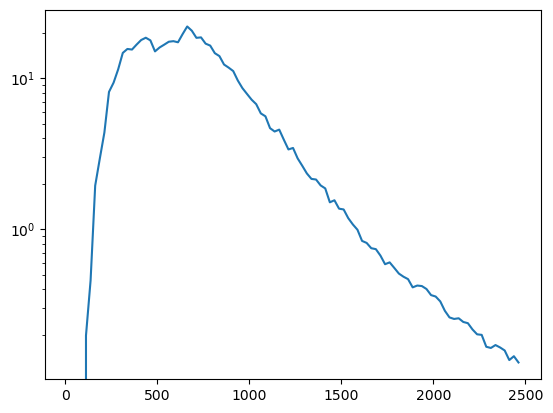

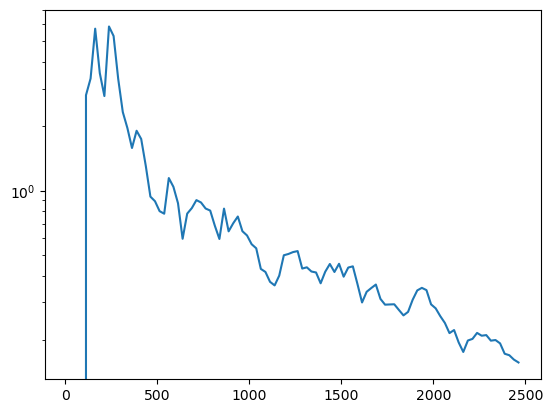

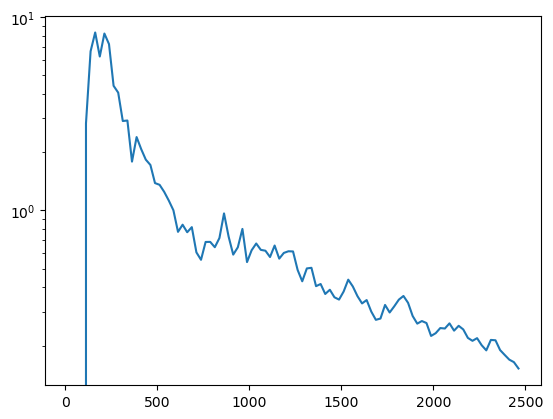

In [13]:
plt.semilogy(ell_b,depth1_TT)
plt.show()
plt.close()

plt.semilogy(ell_b,depth1_EE)
plt.show()
plt.close()

plt.semilogy(ell_b,depth1_BB)
plt.show()
plt.close()

In [14]:
print(depth1_TT)
print(ell_b)

[ 0.          0.          0.          0.          0.19745468  0.45745917
  1.94512596  2.93303283  4.37743268  8.1306631   9.36572189 11.48717204
 14.74710279 15.6608827  15.51808625 16.74044035 17.95688309 18.58880468
 17.85171689 15.09345559 16.02052909 16.7221777  17.48669385 17.63677398
 17.34124449 19.64567082 22.07006365 20.68920804 18.56045767 18.68410881
 16.98447067 16.48220996 14.68650786 14.04276471 12.3514731  11.78214176
 11.17556909  9.67541477  8.61344345  7.88169379  7.21933778  6.74310088
  5.85707389  5.60357515  4.67699339  4.44297328  4.57298396  3.92042456
  3.37989564  3.45650671  2.94899819  2.63570439  2.34450849  2.15592939
  2.1357345   1.95181656  1.86484485  1.50823434  1.55606011  1.36876171
  1.35256371  1.1842106   1.07594826  0.9924836   0.83699946  0.81137627
  0.74869674  0.73808884  0.66859669  0.58654183  0.60316745  0.55448483
  0.50847344  0.48475442  0.46689305  0.41195527  0.42346378  0.42015796
  0.40173382  0.36603309  0.35809909  0.33243823  0

In [10]:
from scipy.optimize import curve_fit
def power_law(x,a,b):
    return a*np.power(x,b)

In [26]:
# Fitting power law to TT, EE, BB to everything after the first five points (35 for TT)
TT_fit, _ = curve_fit(f=power_law, xdata=ell_b[35:], ydata=depth1_TT[35:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_EE[5:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit, _ = curve_fit(f=power_law, xdata=ell_b[5:], ydata=depth1_BB[5:], p0=[0,0],bounds=(-np.inf,np.inf))

[ 1.78790216e+13 -4.12596720e+00]


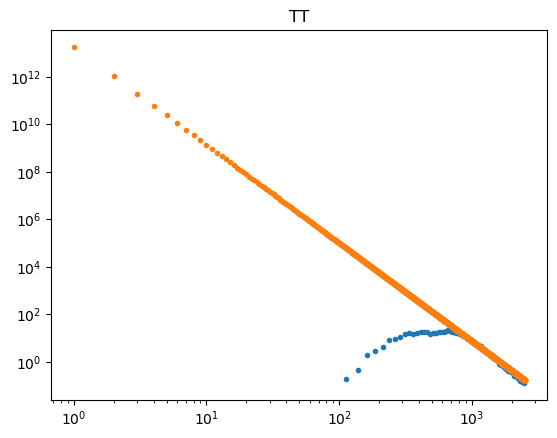

[ 1.15638532e+03 -1.08471351e+00]


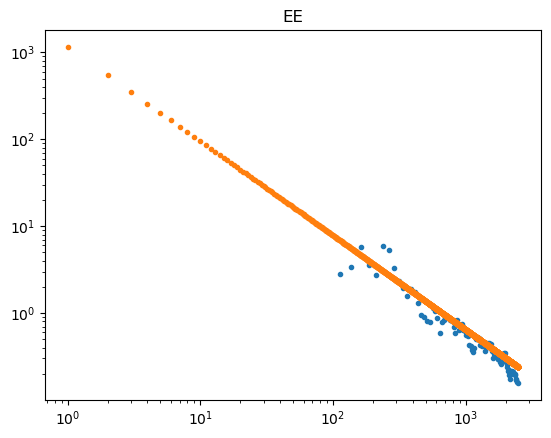

[ 1.78790216e+13 -4.12596720e+00]


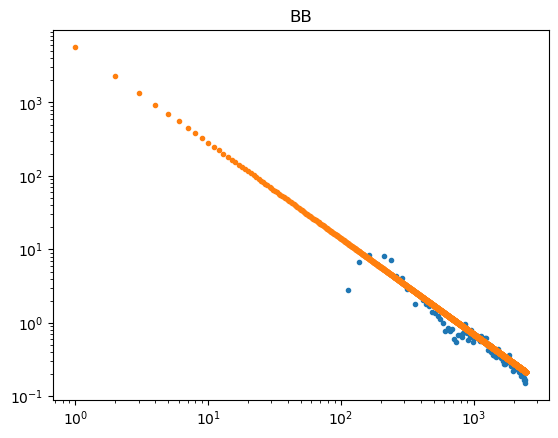

In [27]:
# Checking fits
print(TT_fit)
plt.loglog(ell_b, depth1_TT, marker=".", ls="none",label = "TT")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit), marker=".", ls="none",label = "fit")
plt.title('TT')
plt.show()
plt.close()
print(EE_fit)
plt.loglog(ell_b, depth1_EE, marker=".", ls="none",label = "EE")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit), marker=".", ls="none",label = "fit")
plt.title('EE')
plt.show()
plt.close()
print(TT_fit)
plt.loglog(ell_b, depth1_BB, marker=".", ls="none",label = "BB")
plt.loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit), marker=".", ls="none",label = "fit")
plt.title('BB')
plt.show()
plt.close()

In [28]:
noise_TT = np.zeros(arr_len)
noise_EE = np.zeros(arr_len)
noise_BB = np.zeros(arr_len)
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT[2:2501] = power_law(np.arange(2,2501), *TT_fit)
noise_EE[2:2501] = power_law(np.arange(2,2501), *EE_fit)
noise_BB[2:2501] = power_law(np.arange(2,2501), *BB_fit)

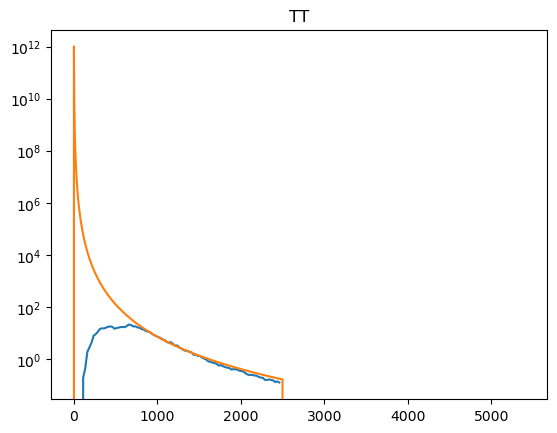

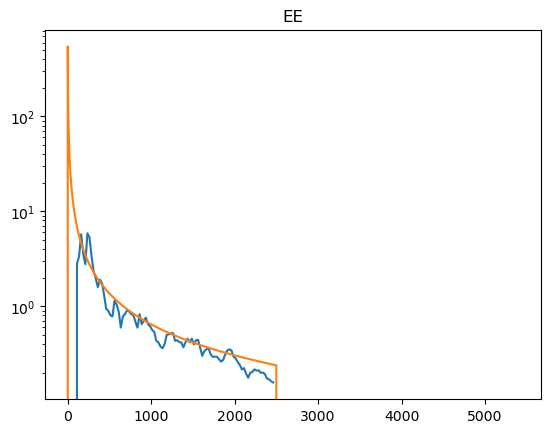

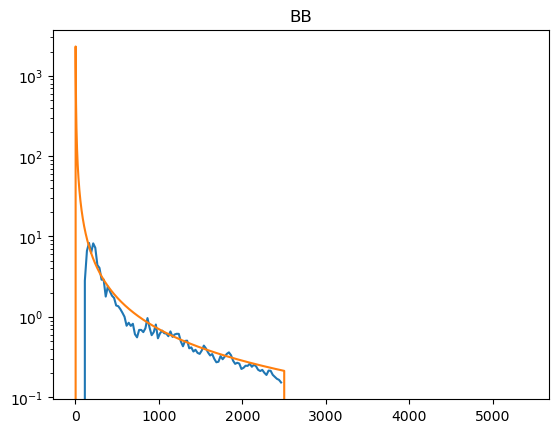

In [29]:
plt.title("TT")
plt.semilogy(ell_b,depth1_TT)
plt.semilogy(range(arr_len),noise_TT)
plt.show()
plt.close()
plt.title("EE")
plt.semilogy(ell_b,depth1_EE)
plt.semilogy(range(arr_len),noise_EE)
plt.show()
plt.close()
plt.title("BB")
plt.semilogy(ell_b,depth1_BB)
plt.semilogy(range(arr_len),noise_BB)
plt.show()
plt.close()

In [30]:
# Doing 500 sims of full sky maps plus noise with an ell range of 200-1000 and a rot angle of 7 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Doing the rotation in PS space instead of map space

# Compared to nb11, uses new noise power law fits
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[7.0])
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT, np.zeros(noise_TT.size), noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range slightly to account for larger starting angle
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)

    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=20.0,num_pts=100000)
    
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:43:36<00:00, 19.63s/it]


Median of full sky percent error, map based estimator: -99.99037476462044
Mean of full sky percent error, map based estimator: -99.99036525001982
Std dev of full sky percent error, map based estimator: 0.0006748652010661169


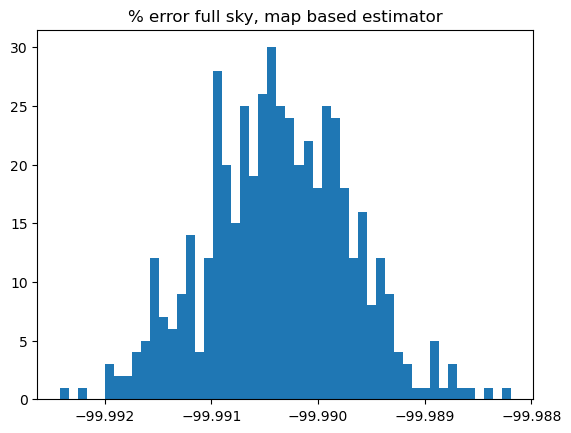

Median of full sky percent error: -18.366717121434384
Mean of full sky percent error: -18.317250295382298
Std dev of full sky percent error: 1.9594786549210073


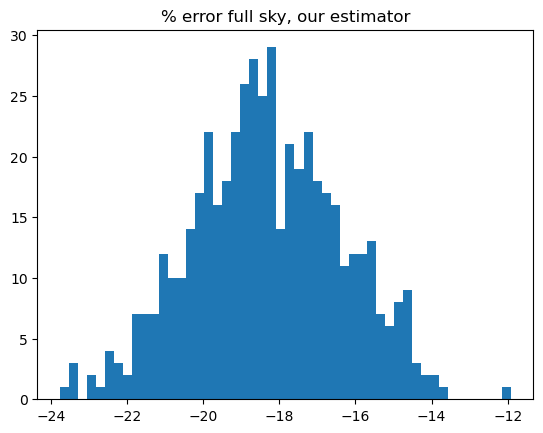

Median of full sky percent error EB estimator: -28.57100577096469
Mean of full sky percent error EB estimator: -28.57097374988929
Std dev of full sky percent error EB estimator: 0.00822941271381609


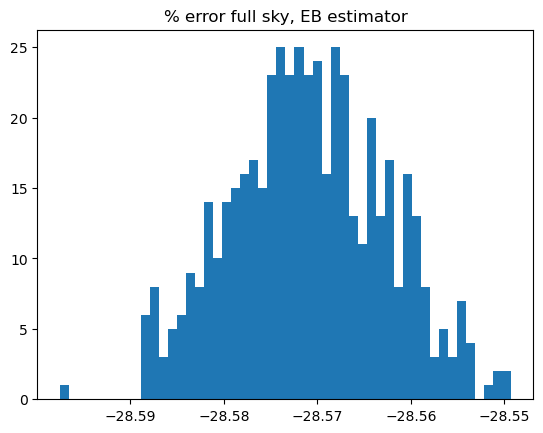

Median of full sky angles Unrot EB estimator: 4.9999908747191695
Mean of full sky angles Unrot EB estimator: 4.99999307843228
Std dev of full sky angles Unrot EB estimator: 0.0005760002462243659


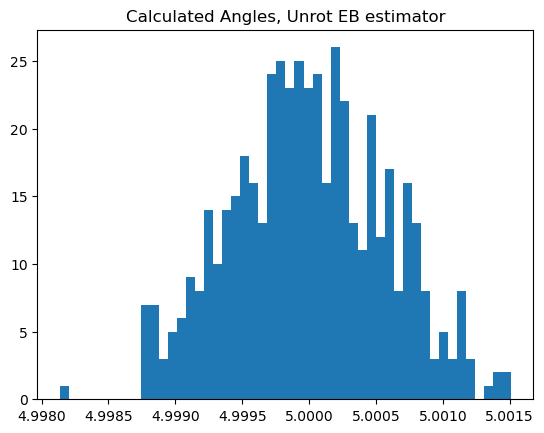

Median of full sky mean TT ratio: 2220.4625264866204
Mean of full sky mean TT ratio: 2220.6969526456287
Std dev of full sky mean TT ratio: 5.329749946584988


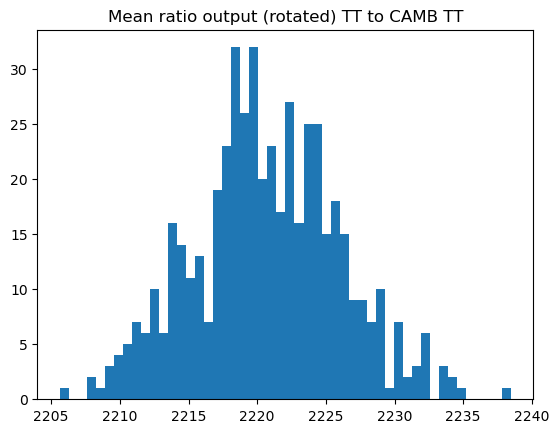

In [31]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
#plt.hist(percent_diff_eb,bins=20,range=(-2,2))
#plt.title("% error full sky, EB estimator, ignoring possible outliers")
#plt.show()
#plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

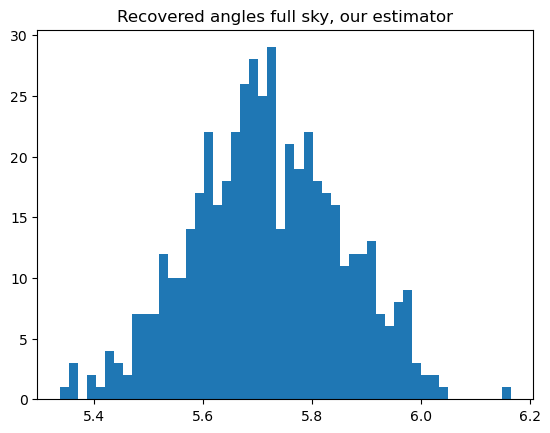

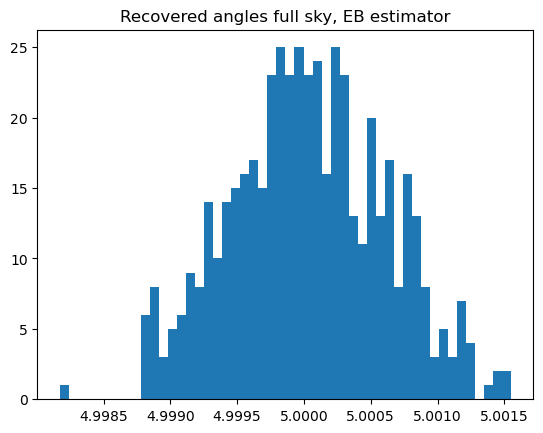

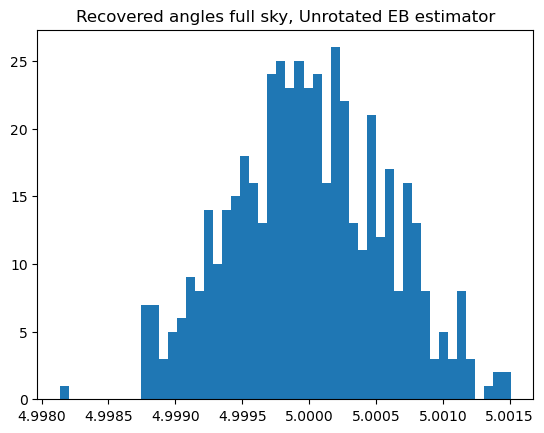

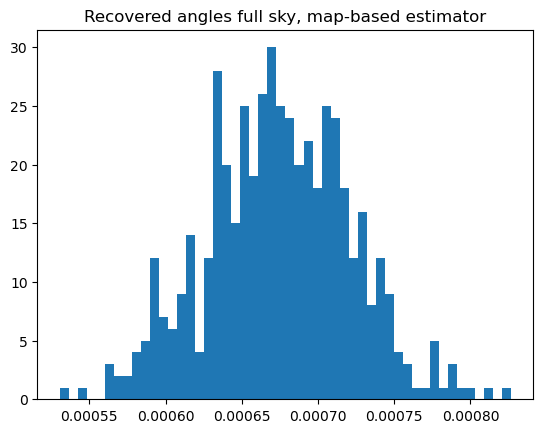

In [32]:
# Plotting the angles by themselves instead of percent difference
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, Unrotated EB estimator")
plt.show()
plt.close()
plt.hist(output_mapspace_angles,bins=50)
plt.title("Recovered angles full sky, map-based estimator")
plt.show()
plt.close()

In [34]:
output_spectra = np.array(output_spectra)

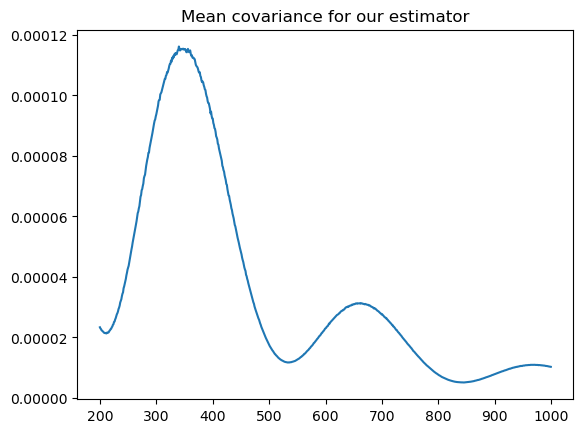

In [35]:
mean_EB = np.mean(output_spectra[:,10],axis=0)
mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)
mean_estimator = np.mean(output_spectra[:,16] - output_spectra[:,22], axis=0)
mean_EE_unrot = np.mean(output_spectra[:,7],axis=0)
mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
mean_BB_unrot = np.mean(output_spectra[:,8],axis=0)
mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)

mean_covariance = ((mean_EE_rot*mean_BB_unrot+mean_EB_cross12**2) \
                  + (mean_EE_unrot*mean_BB_rot+mean_EB_cross21**2) \
                  - 2*(mean_EE_cross12*mean_BB_cross12+mean_EB_rot*mean_EB))

plt.title("Mean covariance for our estimator")
plt.plot(ell_hp,mean_covariance)
plt.show()
plt.close()

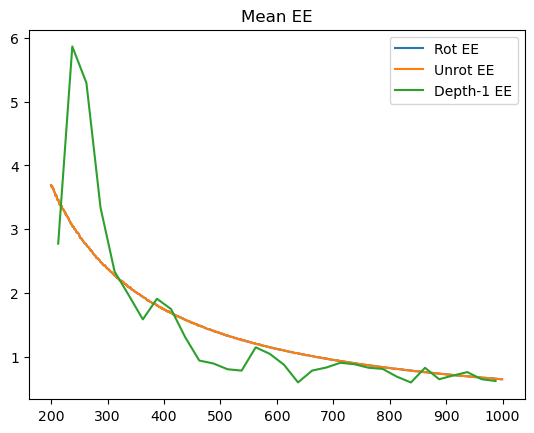

In [51]:
plt.title("Mean EE")
plt.plot(ell_hp,mean_EE_rot,label='Rot EE')
plt.plot(ell_hp,mean_EE_unrot,label="Unrot EE")
plt.plot(ell_b[8:40],depth1_EE[8:40],label='Depth-1 EE')
plt.legend()
plt.show()
plt.close()

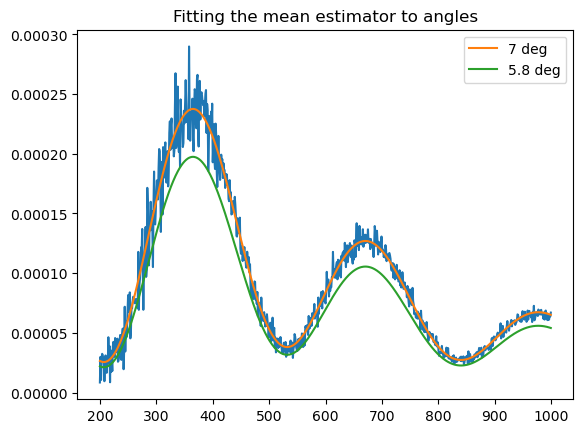

In [36]:
plt.title("Fitting the mean estimator to angles")
plt.plot(ell_hp,mean_estimator)
plot_angle = np.deg2rad(7.0)
plot_angle2 = np.deg2rad(5.8)
plt.plot(ell_hp,1.0*ClEE[min_ell:max_ell]*np.sin(2*plot_angle),label='7 deg')
plt.plot(ell_hp,1.0*ClEE[min_ell:max_ell]*np.sin(2*plot_angle2),label='5.8 deg')# Minus sign flip because of getting estimator sign wrong?
#plt.plot(ell_hp,0.5*ClEE[min_ell:max_ell]*np.sin(4*plot_angle))
plt.legend()
plt.show()
plt.close()

In [54]:
angles_deg = np.linspace(-60.0,60.0,num=100000)
angles_rad = np.deg2rad(angles_deg)
    
bin_sampled_likelihood = []
    
for angle in angles_rad:
    likelihood = estimator_likelihood(angle,mean_estimator,mean_covariance,ClEE[min_ell:max_ell])
    bin_sampled_likelihood.append(likelihood)

norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)

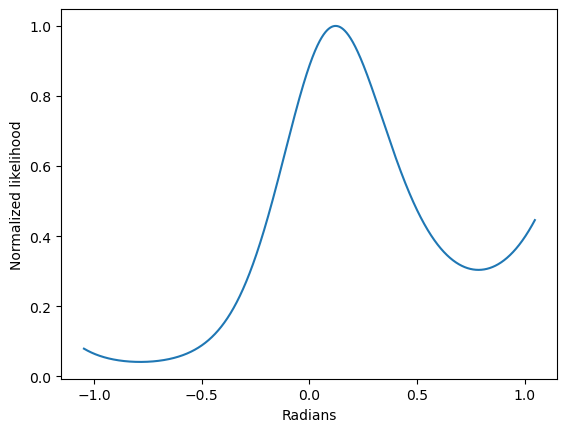

In [55]:
plt.plot(angles_rad,norm_sampled_likelihood)
plt.ylabel("Normalized likelihood")
plt.xlabel("Radians")
plt.show()
plt.close()

It seems that the covariance is worst at ell of 200-500 where the noise is considerably higher. Because of the NSIDE we are using for the sims, we don't want to go higher than ell of 1000, but we could consider a smaller range that has less of this larger (or mid) scale noise.

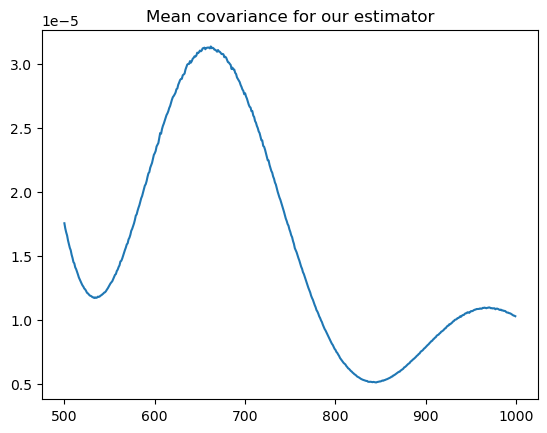

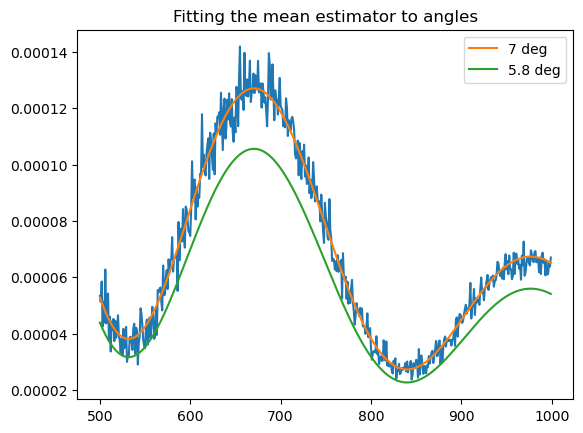

In [58]:
plt.title("Mean covariance for our estimator")
plt.plot(ell_hp[300:],mean_covariance[300:])
plt.show()
plt.close()
plt.title("Fitting the mean estimator to angles")
plt.plot(ell_hp[300:],mean_estimator[300:])
plot_angle = np.deg2rad(7.0)
plot_angle2 = np.deg2rad(5.8)
plt.plot(ell_hp[300:],1.0*ClEE[min_ell+300:max_ell]*np.sin(2*plot_angle),label='7 deg')
plt.plot(ell_hp[300:],1.0*ClEE[min_ell+300:max_ell]*np.sin(2*plot_angle2),label='5.8 deg')# Minus sign flip because of getting estimator sign wrong?
plt.legend()
plt.show()
plt.close()

In [59]:
angles_deg = np.linspace(-60.0,60.0,num=100000)
angles_rad = np.deg2rad(angles_deg)
    
bin_sampled_likelihood = []
    
for angle in angles_rad:
    likelihood = estimator_likelihood(angle,mean_estimator[300:],mean_covariance[300:],ClEE[min_ell+300:max_ell])
    bin_sampled_likelihood.append(likelihood)

norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)

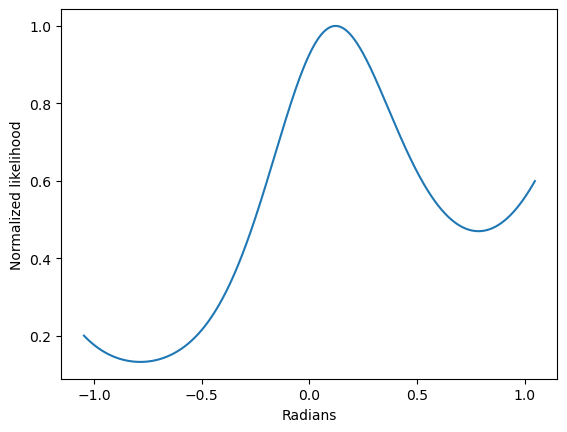

In [60]:
plt.plot(angles_rad,norm_sampled_likelihood)
plt.ylabel("Normalized likelihood")
plt.xlabel("Radians")
plt.show()
plt.close()

It seems that the corresponding drop in signal in the estimator and fewer points to average over prevented the lower noise region from improving our signal-to-noise ratio.